In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Constants used to interact with Azure Blob Storage using the hdfs command or Spark

global username

username = re.sub('@.*', '', getpass.getuser())

global azure_account_name
global azure_data_container_name
global azure_user_container_name
global azure_user_token

azure_account_name = "madsstorage002"
azure_data_container_name = "campus-data"
azure_user_container_name = "campus-user"
azure_user_token = r"sp=racwdl&st=2025-08-01T09:41:33Z&se=2026-12-30T16:56:33Z&spr=https&sv=2024-11-04&sr=c&sig=GzR1hq7EJ0lRHj92oDO1MBNjkc602nrpfB5H8Cl7FFY%3D"


# Functions used below

def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")

        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://localhost:{sc.uiWebUrl.split(":")[-1]}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username} (notebook)</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{username}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.driver.memory", f'{master_memory}g')
        .config("spark.executor.memory", f'{worker_memory}g')
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.kubernetes.container.image", "madsregistry001.azurecr.io/hadoop-spark:v3.3.5-openjdk-8")
        .config("spark.kubernetes.container.image.pullPolicy", "IfNotPresent")
        .config("spark.kubernetes.memoryOverheadFactor", "0.3")
        .config("spark.memory.fraction", "0.1")
        .config(f"fs.azure.sas.{azure_user_container_name}.{azure_account_name}.blob.core.windows.net",  azure_user_token)
        .config("spark.app.name", f"{username} (notebook)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

### Spark notebook ###

This notebook will only work in a Jupyter notebook or Jupyter lab session running on the cluster master node in the cloud.

Follow the instructions on the computing resources page to start a cluster and open this notebook.

**Steps**

1. Connect to the Windows server using Windows App.
2. Connect to Kubernetes.
3. Start Jupyter and open this notebook from Jupyter in order to connect to Spark.

In [ ]:
# Write your imports here or insert cells below


from IPython.display     import display  # calls between environments
from math                import acos, atan2, cos, radians, sin, sqrt
from matplotlib.ticker   import FuncFormatter, MaxNLocator
from pathlib             import Path
from pyspark.sql         import DataFrame
from pyspark.sql         import DataFrame as SparkDF
from pyspark.sql         import functions as F, types as T
from pyspark.sql.types   import *
from pyspark.sql.utils   import AnalysisException
from pyspark.sql.window  import Window
from typing              import List, Optional, Tuple

import itertools         as it
import matplotlib.dates  as mdates
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import math, os, platform, re
import subprocess, sys, time


In [ ]:
print("_" * 35 + "HELPER / DIAGNOSTIC FUNCTIONS" + "_" * 35)

notebook_run_time = time.time()

def df_as_html(df, n: int = 5, right_align: bool = False, show_index: bool = False):
    """
    HTML preview via pandas with no truncation. If right_align=True,
    only numeric columns are right-justified; everything else is 
    explicitly left-aligned.
    """
    
    pdf = df.limit(n).toPandas()
    print("[INFO] Converting Spark → pandas for HTML display (rows:", len(pdf), ")")
    print("[INFO] right_align (numeric columns):", right_align)

    with pd.option_context(
        "display.max_colwidth", None,   
        "display.max_columns", None,    
        "display.width", None            
    ):
        styler = pdf.style if show_index else pdf.style.hide(axis="index")

        #   table alignment: left for both headers and cells
        styler = styler.set_table_styles(
            [
                {"selector": "th", "props": [("text-align", "left")]},
                {"selector": "td", "props": [("text-align", "left")]},
            ],
            overwrite=True,  # make this the baseline
        )
         
        if right_align:
            numeric_cols = list(pdf.select_dtypes(include=["number"]).columns)
            print("[INFO] Right-aligning numeric columns:", numeric_cols)
            if numeric_cols:
                styler = styler.set_properties(subset=numeric_cols,
                                               **{"text-align": "right"})
        display(styler)

def _normalise_dir(s: str) -> str:
    """
    Ensure trailing slash so we point to
    the dataset directory (not a file)
    """
    return s if s.endswith("/") else s + "/"

def ensure_dir(path: str) -> str:
    """
    ensures that path is a path 
    and not representing a file;
    add trailing slash if needed
    """
    if path is None:
        raise ValueError("Path is None")
    path = _normalise_dir(path)
#   print("ensure_dir -> ",path)
    return path
    
def show_df(df, n: int = 10, name: str = "", right_align: bool = False):
    """
    Print schema, 
    show an HTML sample,
    and row count.
    """
    bprint()
    print("name : ",name)
    df.printSchema()
    print("[check] sample:")
    df_as_html(df, n=n, right_align=right_align)
  
def write_parquet(df, dir_as_path: str, df_name:str = ""):    
    funct_time = time.time()
    path = _normalise_dir(dir_as_path)
    print(f"[file] write_parquet  : {path}")
    try:      
        show_df(df,df_name)
    except Exception as e:
        print("[cathch] sample failed:", e)
        os.system(f'hdfs dfs -rm -r -f "{path}"')   # idempotent cleanup
    df.write.mode("overwrite").format("parquet").save(path)
    os.system(f'hdfs dfs -ls -R "{path}"')
    funct_time = time.time() - funct_time 
    print(f"[time] write_parquet (min)   : {funct_time/60:5.2f}")
    print(f"[time] write_parquet (sec)   : {funct_time:5.2f}")
  
def has_parquet(dir_as_path: str) -> bool:
    path   = _normalise_dir( dir_as_path)
    marker = path + '_SUCCESS'
    #print("\n[check] dir_path:", dir_path)
    #print("\n[check] path    :", path)
    print("\n[check] marker  :", marker)
    rc = os.system(f'hdfs dfs -test -e "{marker}"')
    print("[check] rc:", rc, "->", ("exists" if rc == 0 else "missing"))
    return (rc == 0)
    
def _to_spark(df_like, schema=None):
    """
    Return a Spark DataFrame  .
    """
    if isinstance(df_like, SparkDF):
        return df_like
    return spark.createDataFrame(df_like, schema=schema) if schema else spark.createDataFrame(df_like)

def _success_exists(target_dir: str) -> bool:
    """
    Check for the Hadoop/Spark _SUCCESS marker;  
    """
    jvm = spark._jvm
    hconf = spark._jsc.hadoopConfiguration()
    try:
        uri = jvm.java.net.URI(target_dir)
        fs = jvm.org.apache.hadoop.fs.FileSystem.get(uri, hconf)
        success = jvm.org.apache.hadoop.fs.Path(target_dir + "_SUCCESS")
        exists = fs.exists(success)
        print(f"[status] _SUCCESS check at: {target_dir}_SUCCESS -> {exists}")
        return bool(exists)
    except Exception as e:
        print(f"[status] _SUCCESS check failed ({e}); attempting read-probe …")
        try:
            spark.read.parquet(target_dir).limit(1).count()
            print(f"[dewstatus59] read-probe succeeded at: {target_dir}")
            return True
        except Exception as e2:
            print(f"[status] read-probe failed ({e2}); treating as not existing.")
            return False
 

def normalise_ids(df: DataFrame, col: str = "ID") -> DataFrame:
    """
    # Single source of truth for ID normalisation 
    Upper + trim + distinct on the given ID column.
    """
    print(f"[INFO] normalise_ids() on column: {col}")
    df.printSchema()
    df.show(20)
    return df.select(F.upper(F.trim(F.col(col))).alias("ID")).distinct()
    df.printSchema()
    df.show(20)
# hack 
_ids       = normalise_ids
canon_ids  = normalise_ids
_canon_ids = normalise_ids
 
def probe_universe(daily_df, stations_df, inv_agg_df, tag=""):
    """
    DIAGNOSTIC
    """
    # quick previews
    daily_df.show(20)
    stations_df.show(20)
    inv_agg_df.show(20)

    print(tag)
    daily_df.printSchema()
    stations_df.printSchema()
    inv_agg_df.printSchema()
    print(tag)

    print("\n" + "_"*70)
    print(f"[PROBE] Station universe check :: {tag}")

    # id universes
    daily_ids   = _ids(daily_df)
    station_ids = _ids(stations_df)
    inv_ids     = _ids(inv_agg_df)

    # counts
    print("[COUNT] daily IDs         :", daily_ids.count())
    print("[COUNT] station IDs (cat) :", station_ids.count())
    print("[COUNT] inventory IDs     :", inv_ids.count())

    # set differences
    print("[DIFF ] daily - station   :", daily_ids.join(station_ids, "ID", "left_anti").count())
    print("[DIFF ] station - daily   :", station_ids.join(daily_ids, "ID", "left_anti").count())
    print("[DIFF ] station - inv     :", station_ids.join(inv_ids,    "ID", "left_anti").count())
    print("[DIFF ] inv - daily       :", inv_ids.join(daily_ids,      "ID", "left_anti").count())
    print("[DIFF ] inv - station     :", inv_ids.join(station_ids,    "ID", "left_anti").count())

    bprint("[done] probe_universe")


def _count_unique_ids(df: DataFrame) -> int:
    return normalise_ids(df).count()

def pick_unfiltered_daily(preferred_path: str = None) -> DataFrame:
    """Return an unfiltered daily DF (~129k unique station IDs)."""
    cand_names = ["daily", "read_daily", "daily_df", "daily_all", "ghcnd_daily"]
    print("[INFO] Candidate DataFrames:", [n for n in cand_names if n in globals()])
    for name in cand_names:
        obj = globals().get(name)
        if isinstance(obj, DataFrame):
            try:
                n = normalise_ids(obj).count()
                print(f"[CHECK] {name} unique station IDs:", n)
                if n >= 120_000:
                    print(f"[INFO] Using {name} as the unfiltered daily.")
                    return obj
            except Exception as e:
                print(f"[WARN] Could not inspect {name}:", repr(e))
    if preferred_path:
        print(f"[INFO] Trying preferred_path: {preferred_path}")
        df = spark.read.parquet(str(preferred_path))
        n = normalise_ids(df).count()
        print("[CHECK] preferred_path unique station IDs:", n)
        if n >= 120_000:
            print("[INFO] Using preferred_path as the unfiltered daily.")
            return df
    for var in ["DAILY_READ_NAME","DAILY_WRITE_NAME","daily_read_name","daily_write_name","DAILY_NAME"]:
        if var in globals():
            path = globals()[var]
            try:
                print(f"[INFO] Trying {var} = {path}")
                df = spark.read.parquet(str(path))
                n = normalise_ids(df).count()
                print(f"[CHECK] {var} unique station IDs:", n)
                if n >= 120_000:
                    print(f"[INFO] Using {var} as the unfiltered daily.")
                    return df
            except Exception as e:
                print(f"[WARN] Could not read {var}:", repr(e))
    raise SystemExit("[FATAL] Could not find an unfiltered daily dataset (expected ~129k unique station IDs).")

def bprint(text: str="", l=50):
    n = len(text)
    n = abs(n - l)//2
    
    print("\n" + "_" * n + text + "_" * n)

# Back-compat aliases hack to account for non-disciplined naming un-convention
_ids       = normalise_ids
canon_ids  = normalise_ids
_canon_ids = normalise_ids

#print("[TEST] Using _canon_ids:", _canon_ids(stations).count())
#print("[TEST] Using canon_ids :", canon_ids(stations).count())
#print("[TEST] Using _ids      :", _ids(stations).count())


# : pairwise city distances in km using Spark built-ins 
def pairwise_city_distances_spark(cities, radius_km=6371.0):
    """
    cities: list[tuple[str, float, float]] -> [(name, lat_deg, lon_deg), ...]
    returns: Spark DataFrame with columns:
             city_a, city_b, haversine_km, slc_km, delta_km, delta_pct
    """
  #  from pyspark.sql import SparkSession, functions as F, types as T

    spark = SparkSession.getActiveSession()
    if spark is None:
        raise RuntimeError("No active Spark session.")

    schema = T.StructType([
        T.StructField("city", T.StringType(), False),
        T.StructField("lat",  T.DoubleType(), False),
        T.StructField("lon",  T.DoubleType(), False),
        ])
    df = spark.createDataFrame(cities, schema)

    a, b = df.alias("a"), df.alias("b")
    pairs = (a.join(b, F.col("a.city") < F.col("b.city"))
               .select(F.col("a.city").alias("city_a"),
                       F.col("b.city").alias("city_b"),
                       F.col("a.lat").alias("lat1"),
                       F.col("a.lon").alias("lon1"),
                       F.col("b.lat").alias("lat2"),
                       F.col("b.lon").alias("lon2")))

    R = F.lit(float(radius_km))
    lat1 = F.radians(F.col("lat1"));  lat2 = F.radians(F.col("lat2"))
    dlat = lat2 - lat1
    dlon = F.radians(F.col("lon2") - F.col("lon1"))

    a_term = F.sin(dlat/2)**2 + F.cos(lat1)*F.cos(lat2)*F.sin(dlon/2)**2
    c_term = 2*F.atan2(F.sqrt(a_term), F.sqrt(1 - a_term))
    hav_km = R * c_term

    cos_val = F.sin(lat1)*F.sin(lat2) + F.cos(lat1)*F.cos(lat2)*F.cos(dlon)
    cos_val = F.greatest(F.lit(-1.0), F.least(F.lit(1.0), cos_val))
    slc_km = R * F.acos(cos_val)

    delta_km  = F.abs(hav_km - slc_km)
    delta_pct = F.when(hav_km == 0, F.lit(0.0)).otherwise(delta_km / hav_km * 100.0)

    out_df = (pairs
              .withColumn("haversine_km", F.round(hav_km, 2))
              .withColumn("slc_km",       F.round(slc_km, 2))
              .withColumn("delta_km",     F.round(delta_km, 4))
              .withColumn("delta_pct",    F.round(delta_pct, 6))
              .select("city_a", "city_b", "haversine_km", "slc_km", "delta_km", "delta_pct")
              .orderBy("haversine_km"))
    return out_df


# --- Timing helpers for Spark & pure Python (no extra deps)
 

def benchmark_python_distances(cities, radius_km=6371.0, repeats=50000):
    """
    cities: [(name, lat_deg, lon_deg), ...]  (3 cities => 3 pairs)
    repeats: loop count to make timings stable
    returns: dict with seconds for haversine/slc
    """
    pairs = []
    for i in range(len(cities)):
        for j in range(i+1, len(cities)):
            (_, lat1, lon1), (_, lat2, lon2) = cities[i], cities[j]
            pairs.append((lat1, lon1, lat2, lon2))

    # haversine
    t0 = perf_counter()
    for _ in range(repeats):
        for lat1, lon1, lat2, lon2 in pairs:
            φ1, λ1, φ2, λ2 = map(radians, (lat1, lon1, lat2, lon2))
            dφ, dλ = (φ2 - φ1), (λ2 - λ1)
            a = sin(dφ/2)**2 + cos(φ1)*cos(φ2)*sin(dλ/2)**2
            c = 2*atan2(sqrt(a), sqrt(1 - a))
            _ = radius_km * c
    t1 = perf_counter()

    # spherical law of cosines (SLC)
    t2 = perf_counter()
    for _ in range(repeats):
        for lat1, lon1, lat2, lon2 in pairs:
            φ1, λ1, φ2, λ2 = map(radians, (lat1, lon1, lat2, lon2))
            cosv = sin(φ1)*sin(φ2) + cos(φ1)*cos(φ2)*cos(λ2 - λ1)
            cosv = max(-1.0, min(1.0, cosv))
            _ = radius_km * acos(cosv)
    t3 = perf_counter()

    return {
        "python_haversine_sec": t1 - t0,
        "python_slc_sec":       t3 - t2,
        "repeats": repeats,
        "pairs": len(pairs),
    }


def _parse_ls_bytes(line): 
    parts = line.split()
    if len(parts) < 8:
        return None, None
    try:
        size = int(parts[4])
    except ValueError:
        return None, None
    return size, parts[-1]

def _parse_du_bytes(line):
    parts = line.split()
    if len(parts) < 2:
        return None, None
    try:
        size = int(parts[0])
    except ValueError:
        return None, None
    return size, parts[-1]

def du_bytes(path):
    lines = get_ipython().getoutput(f'hdfs dfs -du "{path}"')
    total = 0
    for ln in lines:
        parts = ln.split()
        if len(parts) >= 2:
            try:
                total += int(parts[0])
            except ValueError:
                pass
    return total
    
def benchmark_spark_distances(cities, radius_km=6368.6, repeats=3):
    """
    Uses Spark built-ins only. Measures full execution
    time by forcing an action.
    
    returns: dict with seconds for haversine/slc and
    row counts used.
    
    For the radius:
    
    The Earth is slightly flattened, so the geocentric 
    radius depends on latitude.  For context: 
    
    * equatorial radius = 6,378.137 km; 
    * polar radius      = 6,356.752 km 
    
    Across New Zealand’s latitudes (≈36–47°S), using the
    WGS-84 ellipsoid, you get roughly:

    Auckland (37°S):       ~6,370.4 km
    Christchurch (43.5°S): ~6,368.0 km
    Dunedin (45.9°S):      ~6,367.2 km
    __________________________________
    Wellington (41°S):     ~6,369.0 km
    mean                  ≈ 6,368.6 km
    """

    
    try:
        from pyspark.sql import SparkSession, functions as F, types as T
    except Exception:
        return None  # no Spark therefore save cannot run in vs code

    spark = SparkSession.getActiveSession()
    if spark is None:
        return None

    # build pairs once and cache
    schema = T.StructType([
        T.StructField("city", T.StringType(), False),
        T.StructField("lat",  T.DoubleType(), False),
        T.StructField("lon",  T.DoubleType(), False),
    ])
    df = spark.createDataFrame(cities, schema)
    a, b = df.alias("a"), df.alias("b")
    pairs = (a.join(b, F.col("a.city") < F.col("b.city"))
               .select(F.col("a.lat").alias("lat1"),
                       F.col("a.lon").alias("lon1"),
                       F.col("b.lat").alias("lat2"),
                       F.col("b.lon").alias("lon2"))
               .cache())
    _ = pairs.count()

    R = F.lit(float(radius_km))
    lat1 = F.radians(F.col("lat1")); lat2 = F.radians(F.col("lat2"))
    dlat = lat2 - lat1
    dlon = F.radians(F.col("lon2") - F.col("lon1"))

    # Haversine expr
    a_term = F.sin(dlat/2)**2 + F.cos(lat1)*F.cos(lat2)*F.sin(dlon/2)**2
    c_term = 2*F.atan2(F.sqrt(a_term), F.sqrt(1 - a_term))
    hav    = R * c_term

    # SLC expr
    cosv = F.sin(lat1)*F.sin(lat2) + F.cos(lat1)*F.cos(lat2)*F.cos(dlon)
    cosv = F.greatest(F.lit(-1.0), F.least(F.lit(1.0), cosv))
    slc = R * F.acos(cosv)

    # time Haversine
    t0 = perf_counter()
    for _ in range(repeats):
        _ = pairs.select(hav.alias("d")).agg(F.sum("d")).collect()
    t1 = perf_counter()

    # time SLC
    t2 = perf_counter()
    for _ in range(repeats):
        _ = pairs.select(slc.alias("d")).agg(F.sum("d")).collect()
    t3 = perf_counter()

    return {
        "spark_pairs": pairs.count(),
        "spark_repeats": repeats,
        "spark_haversine_sec": t1 - t0,
        "spark_slc_sec":       t3 - t2,
    }


In [ ]:
bprint("SECTION 1: ENVIRONMENT SETUP")
# supports: Assignment Setup — "Configure global variables and paths required for GHCN data processing"
# does: initializes runtime tracking, configures Azure storage paths, defines data locations,
#       establishes file paths, and sets debug flags for conditional processing

notebook_run_time = time.time()
val               = spark.range(1).select(F.date_format(F.current_timestamp(), 'yyyy.MM.dd HH:mm').alias('t')).first()['t']
bprint()
print(f"[time] current time           :  {val}")
bprint()


bprint("ENVIRONMENT") 
print("Spark       :", spark.version)
print("Python tuple:", sys.version_info[:3]) 
print("username    :", username)
print()

bprint("DEEBUG BOOLEANS")
#FORCE_OVERWRITE = False  # False means that if the file exists then we wont re-write it 
#FORCE_OVERWRITE = True   # True means overwrite all resultant files
FORCE_REBUILD_ENRICHED  = True   #has_parquet(enriched_write_name)
FORCE_REBUILD_INV_AGG = True    # has_parquet(inv_agg_write_name)

FORCE_REBUILD_STATIONS  = True    #has_parquet(stations_write_name)
FORCE_REBUILD_INVENTORY = True    # has_parquet(inventory_write_name)
FORCE_REBUILD_STATES    = True    #has_parquet(states_write_name)
FORCE_REBUILD_COUNTRIES = True    #has_parquet(countries_write_name)
FORCE_REBUILD_INV_AGG = True    # has_parquet(inv_agg_write_name)

FORCE_REBUILD_OVERLAP   = True    #has_parquet(overlap_write_name)
FORCE_REBUILD_PRECIP    = True    #has_parquet(precip_write_path)

print(f"[status] FORCE_REBUILD_ENRICHED  :", FORCE_REBUILD_ENRICHED)
print(f"[status] FORCE_REBUILD_INV_AGG   :", FORCE_REBUILD_INV_AGG)
print(f"[status] FORCE_REBUILD_STATIONS  :", FORCE_REBUILD_STATIONS)
print(f"[status] FORCE_REBUILD_INVENTORY :", FORCE_REBUILD_INVENTORY)
print(f"[status] FORCE_REBUILD_STATES    :", FORCE_REBUILD_STATES)
print(f"[status] FORCE_REBUILD_COUNTRIES :", FORCE_REBUILD_COUNTRIES)

print(f"[status] FORCE_REBUILD_OVERLAP   :", FORCE_REBUILD_OVERLAP)
print(f"[status] FORCE_REBUILD_PRECIP    :", FORCE_REBUILD_PRECIP)

bprint("SOURCE FOLDERS")
print()

azure_account_name        = "madsstorage002"
azure_data_container_name = "campus-data"
azure_user_container_name = "campus-user"
previous_year             = 2024  # full hear
most_recent_year          = 2025  # currently building


print("azure_account_name        :", azure_account_name)
print("azure_data_container_name :", azure_data_container_name)
print("azure_user_container_name :", azure_user_container_name)
print("previous_year             :", previous_year)
print("most_recent_year          :", most_recent_year)
print()

data_root      = f"wasbs://{azure_data_container_name}@{azure_account_name}.blob.core.windows.net/ghcnd/"
user_root      = f"wasbs://{azure_user_container_name}@{azure_account_name}.blob.core.windows.net/{username}/"
 
data_root      = ensure_dir(data_root)
user_root      = ensure_dir(user_root) 

print("data_root           :", data_root) 
print("user_root           :", user_root)
bprint()

daily_root     = ensure_dir(f"{data_root}daily/")

print("daily_root          :", daily_root)
print()

aux_root = "../auxiliary/"
aux_root = ensure_dir(aux_root)

reports_dir  = ensure_dir(f"{aux_root}reports/")
images_dir   = ensure_dir(f"{aux_root}images/")
figures_dir  = ensure_dir(f"{aux_root}figures/") 


print("aux_root    :", aux_root)
print("reports_dir :", reports_dir)
print("images_dir  :", images_dir)
print("figures_dir :", figures_dir)
print()



bprint("SOURCE FILES")
stations_read_name   = f'{data_root}ghcnd-stations.txt'
inventory_read_name  = f'{data_root}ghcnd-inventory.txt'
countries_read_name  = f'{data_root}ghcnd-countries.txt'
states_read_name     = f'{data_root}ghcnd-states.txt'


print("stations_read_name  :", stations_read_name)
print("inventory_read_name :", inventory_read_name)
print("countries_read_name :", countries_read_name)
print("states_read_name    :", states_read_name)
print()

previous_csvgz_path  = f'{daily_root}2024.csv.gz' 
current_csvgz_path   = f'{daily_root}2025.csv.gz' 


print("previous_csvgz_path  :", previous_csvgz_path)
print("current_csvgz_path   :", current_csvgz_path)
print()
bprint("USER FOLDERS")
  
stations_write_name  =  ensure_dir(f'{user_root}stations.parquet')      #parquest file referenced by folder
inventory_write_name =  ensure_dir(f'{user_root}inventory.parquet')
countries_write_name =  ensure_dir(f'{user_root}countries.parquet')
states_write_name    =  ensure_dir(f'{user_root}states.parquet') 

inv_agg_write_name   = ensure_dir(f'{user_root}inv_agg.parquet')
enriched_write_name  = ensure_dir(f'{user_root}enriched_write_name.parquet')

print()
print("stations_write_name  :", stations_write_name)
print("inventory_write_name :", inventory_write_name)
print("countries_write_name :", countries_write_name)
print("states_write_name    :", states_write_name)
print("inv_agg_write_name   :", inv_agg_write_name)
print()
print("enriched_write_name :", enriched_write_name)
print("enriched_write_name :", enriched_write_name)

#overlap_write_pathh  = ensure_dir(f'{user_root}q1b32_overlap_counts.parquet')
#precip_write_path    = ensure_dir(f'{user_root}q2a-agg-precipitation.parquet')
 
print("inv_agg_write_name  :", inv_agg_write_name)
station_date_element = ensure_dir(f"{user_root}q2a_station_date_element.parquet")
overlap_counts_name  = ensure_dir(f'{user_root}q1b32_overlap_counts.parquet')
overlap_write_name   = ensure_dir(f'{user_root}q1b32_overlap_counts.parquet')
precip_write_name    = ensure_dir(f'{user_root}q2a-agg-precipitation.parquet') 
print()

inv_agg_write_name   = ensure_dir(f'{user_root}inv_agg.parquet') 

print()
print("stations_write_name :", stations_write_name)
print("overlap_counts_name :", overlap_counts_name)
print("overlap_write_name  :", overlap_write_name)
print("precip_write_name   :", precip_write_name) 

In [ ]:
bprint("Analysis Q1(a)0")
cell_time = time.time()
 
print(f"[check] user_root: {user_root}")   
print(f"[check] enriched : {enriched_write_name}") 

path = str(enriched_write_name)
print("[CHECK] Verifying HDFS path exists:", path)

try:
    # -test -e returns non-zero if the file/dir does not exist
    subprocess.run(["hdfs", "dfs", "-test", "-e", user_root], check=True)
    print("[CHECK] Path exists.")
except subprocess.CalledProcessError as e:
    print("[ERROR] HDFS path missing or inaccessible. Return code:", e.returncode)
    # Optional: show a listing attempt for context
    subprocess.run(["hdfs", "dfs", "-ls", "-h", path], check=False)
    raise SystemExit("[FATAL] Aborting notebook: required dataset not found.")

!hdfs dfs -du -s -h {enriched_write_name} 
!hdfs dfs -ls    -h {enriched_write_name}   
enriched = spark.read.parquet(enriched_write_name).cache()
print("[check] enriched rows:", enriched.count()); show_df(enriched, name="enriched")

cell_time = time.time() - cell_time
print(f"[time] Cell time (sec): {cell_time:6.2f}") 
print(f"[time] Cell time (min): {cell_time/60:6.2f}") 
print(f"[time] notebook_run_time (min): {(time.time() - notebook_run_time)/60:5.2f}")

In [ ]:
bprint("Analysis Q1(a)1") # Q1(a)1 – Basic counts and active in 2025 
cell_time = time.time() 

total = enriched.select("ID").distinct().count()

active_2025 = (
    enriched.where((F.col("FIRSTYEAR") <= 2025) & (F.col("LASTYEAR") >= 2025))
    .select("ID").distinct().count()
)

gsn = enriched.filter(F.col("GSN_FLAG")    == "GSN").select("ID").distinct().count()
hcn = enriched.filter(F.col("HCNCRN_FLAG") == "HCN").select("ID").distinct().count()
crn = enriched.filter(F.col("HCNCRN_FLAG") == "CRN").select("ID").distinct().count()

print()
bprint()
print(f"[result] Total stations          : {total:9,d}")
print(f"[result] Active in 2025          : {active_2025:9,d}")
print(f"[result] GSN stations            : {gsn:9,d}")
print(f"[result] HCN stations            : {hcn:9,d}")
print(f"[result] CRN stations            : {crn:9,d}")

cell_time = time.time() - cell_time
print(f"[time] Cell time (sec)        : {cell_time:6.2f}") 
print(f"[time] Cell time (min)        : {cell_time/60:6.2f}") 
print(f"[time] notebook_run_time (min): {(time.time() - notebook_run_time)/60:5.2f}")

In [ ]:
bprint("Analysis Q1(a)2") #  – Overlaps between networks 
cell_time = time.time() 

gsn_ids = enriched.filter(F.col("GSN_FLAG")    == "GSN").select("ID").distinct()
hcn_ids = enriched.filter(F.col("HCNCRN_FLAG") == "HCN").select("ID").distinct()
crn_ids = enriched.filter(F.col("HCNCRN_FLAG") == "CRN").select("ID").distinct()

# Overlaps
gsn_hcn = gsn_ids.intersect(hcn_ids).count()
gsn_crn = gsn_ids.intersect(crn_ids).count()
hcn_crn = hcn_ids.intersect(crn_ids).count()
all_three = gsn_ids.intersect(hcn_ids).intersect(crn_ids).count()

print()
bprint()
print(f"[result] GSN ∩ HCN stations    : {gsn_hcn:5,d}")
print(f"[result] GSN ∩ CRN stations    : {gsn_crn:5,d}")
print(f"[result] HCN ∩ CRN stations    : {hcn_crn:5,d}")
print(f"[result] All three             : {all_three:5,d}")

cell_time = time.time() - cell_time
print(f"[time] Cell time (sec): {cell_time:6.2f}") 
print(f"[time] Cell time (min): {cell_time/60:6.2f}") 
print(f"[time] notebook_run_time (min): {(time.time() - notebook_run_time)/60:5.2f}")

In [ ]:
bprint("Analysis Q1(a)") # Counts from  Analysis Q1(a)

# Ensure output directory exists 
os.makedirs(figs_dir, exist_ok=True)
print(f"[result] output directory confirmed: {os.path.abspath(figs_dir)}")

counts = {
    "GSN": int(gsn),
    "HCN": int(hcn),
    "CRN": int(crn),
    "GSN ∩ HCN": int(gsn_hcn),
    "GSN ∩ CRN": int(gsn_crn),
    "HCN ∩ CRN": int(hcn_crn),
    "All three": int(all_three),
}
order = ["GSN", "HCN", "CRN", "GSN ∩ HCN", "GSN ∩ CRN", "HCN ∩ CRN", "All three"]
labels = order
values = [counts[k] for k in order]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, values)
plt.bar(counts.keys(), counts.values())
plt.ylabel("Number of stations")
plt.title("Station membership and overlaps (GSN, HCN, CRN)")
plt.xticks(rotation=0, ha="center")
plt.tight_layout()
# Add the numbers on top of each bar
for b in bars:
    height = b.get_height()
    plt.text(b.get_x() + b.get_width()/2,
             height,
             f"{int(height)}",
             ha="center",
             va="bottom")



plt.tight_layout()
outfile = os.path.join(figs_dir, "barchart-station-metadata-analysis.png")
plt.savefig(outfile, dpi=300)
print(f"[file] barchart saved -> {outfile}")
plt.show()
#plt.close()

cell_time = time.time() - cell_time  
print(f"[time] Cell time (sec): {cell_time:6.2f}") 
print(f"[time] Cell time (min): {cell_time/60:6.2f}") 
print(f"[time] notebook_run_time (min): {(time.time() - notebook_run_time)/60:5.2f}")

In [ ]:
bprint("Q1(b)1") # Q1(b)1 – Coverage queries 
cell_time = time.time()
south_hem = enriched.filter(F.col("LATITUDE") < 0).select("ID").distinct().count()

us_territories = enriched.filter(
    (F.col("COUNTRY_CODE") == "US") &
    (F.col("STATE").isin(["PR","GU","AS","VI","MP"]))
).select("ID").distinct().count()

century_stations = enriched.filter(
    (F.col("LASTYEAR") - F.col("FIRSTYEAR") + 1) >= 100
).select("ID").distinct().count()

print()
bprint()
print(f"[result] Southern Hemisphere stations : {south_hem:12,d}")
print(f"[result] U.S. territory stations      : {us_territories:12,d}")
print(f"[result] ≥100-year stations           : {century_stations:12,d}")

cell_time = time.time() - cell_time
print(f"[time] Cell time (sec): {cell_time:6.2f}") 
print(f"[time] Cell time (min): {cell_time/60:6.2f}") 
print(f"[time] notebook_run_time (min): {(time.time() - notebook_run_time)/60:5.2f}")


__________________Analysis Q1(a)__________________
[result] output directory confirmed: /home/dew59/m-ghcn/code/figures
[file] barchart saved -> figures/barchart-station-metadata-analysis.png


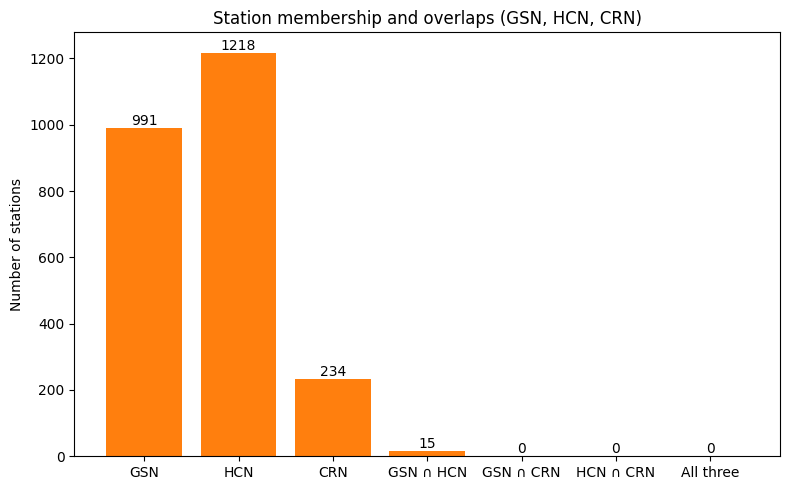

[time] Cell time (sec): 1757861038.04
[time] Cell time (min): 29297683.97
[time] notebook_run_time (min):  0.32


In [9]:
bprint("Analysis Q1(a)") # Counts from  Analysis Q1(a)

# Ensure output directory exists 
os.makedirs(figs_dir, exist_ok=True)
print(f"[result] output directory confirmed: {os.path.abspath(figs_dir)}")

counts = {
    "GSN": int(gsn),
    "HCN": int(hcn),
    "CRN": int(crn),
    "GSN ∩ HCN": int(gsn_hcn),
    "GSN ∩ CRN": int(gsn_crn),
    "HCN ∩ CRN": int(hcn_crn),
    "All three": int(all_three),
}
order = ["GSN", "HCN", "CRN", "GSN ∩ HCN", "GSN ∩ CRN", "HCN ∩ CRN", "All three"]
labels = order
values = [counts[k] for k in order]

plt.figure(figsize=(8,5))
bars = plt.bar(labels, values)
plt.bar(counts.keys(), counts.values())
plt.ylabel("Number of stations")
plt.title("Station membership and overlaps (GSN, HCN, CRN)")
plt.xticks(rotation=0, ha="center")
plt.tight_layout()
# Add the numbers on top of each bar
for b in bars:
    height = b.get_height()
    plt.text(b.get_x() + b.get_width()/2,
             height,
             f"{int(height)}",
             ha="center",
             va="bottom")



plt.tight_layout()
outfile = os.path.join(figs_dir, "barchart-station-metadata-analysis.png")
plt.savefig(outfile, dpi=300)
print(f"[file] barchart saved -> {outfile}")
plt.show()
#plt.close()

cell_time = time.time() - cell_time  
print(f"[time] Cell time (sec): {cell_time:6.2f}") 
print(f"[time] Cell time (min): {cell_time/60:6.2f}") 
print(f"[time] notebook_run_time (min): {(time.time() - notebook_run_time)/60:5.2f}")


In [10]:
bprint("Q1(b)1") # Q1(b)1 – Coverage queries 
cell_time = time.time()
south_hem = enriched.filter(F.col("LATITUDE") < 0).select("ID").distinct().count()

us_territories = enriched.filter(
    (F.col("COUNTRY_CODE") == "US") &
    (F.col("STATE").isin(["PR","GU","AS","VI","MP"]))
).select("ID").distinct().count()

century_stations = enriched.filter(
    (F.col("LASTYEAR") - F.col("FIRSTYEAR") + 1) >= 100
).select("ID").distinct().count()

print()
bprint()
print(f"[result] Southern Hemisphere stations : {south_hem:12,d}")
print(f"[result] U.S. territory stations      : {us_territories:12,d}")
print(f"[result] ≥100-year stations           : {century_stations:12,d}")

cell_time = time.time() - cell_time
print(f"[time] Cell time (sec): {cell_time:6.2f}") 
print(f"[time] Cell time (min): {cell_time/60:6.2f}") 
print(f"[time] notebook_run_time (min): {(time.time() - notebook_run_time)/60:5.2f}")


______________________Q1(b)1______________________


__________________________________________________
[result] Southern Hemisphere stations :       25,357
[result] U.S. territory stations      :            0
[result] ≥100-year stations           :        6,824
[time] Cell time (sec):   0.74
[time] Cell time (min):   0.01
[time] notebook_run_time (min):  0.33


In [11]:
bprint(" Q1(c)1") # – Coverage of the 5 core elements
 
cell_time = time.time() 
# Stations with at least 1 core element
core_stations = enriched.filter(F.col("CORE_ELEMENT_COUNT") > 0).count()

# Stations with all 5 core elements
all5 = enriched.filter(F.col("CORE_ELEMENT_COUNT") == 5).count()

print()
bprint()
print(f"[result] Stations with ≥1 core element : {core_stations:12,d}")
print(f"[result] Stations with all 5 core      : {all5:12,d}")

cell_time = time.time() - cell_time
print(f"[time] Cell time (sec): {cell_time:6.2f}") 
print(f"[time] Cell time (min): {cell_time/60:6.2f}") 
print(f"[time] notebook_run_time (min): {(time.time() - notebook_run_time)/60:5.2f}")


_____________________ Q1(c)1_____________________


__________________________________________________
[result] Stations with ≥1 core element :      129,570
[result] Stations with all 5 core      :       20,504
[time] Cell time (sec):   0.24
[time] Cell time (min):   0.00
[time] notebook_run_time (min):  0.33



___________________TWO FIGURES___________________
[status] Computing station counts for requested views...
[status] south_hem (all SH): 25357
[status] north_hem (all NH): 104300
[status] us_territories_all (global, excl. US states): 0
[status] us_territories_south (south of equator): 0
[status] century_global (≥100 years, global): 6824
[status] nz_all: 15
[status] Fig1 Labels: ['Southern\nHemisphere', 'US territories\n(south of equator)', '≥100 years (global)']
[status] Fig1 Values: [25357, 0, 6824]
[status] Figure 1 saved to: figures/dew59_bar_southern_focus.png


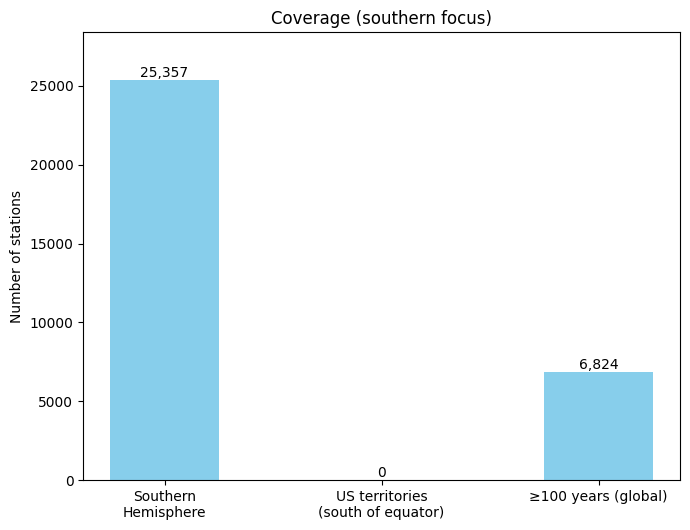

[status] Fig2 Labels: ['Northern\nHemisphere', 'Southern\nHemisphere', 'New Zealand\n(all)']
[status] Fig2 Values: [104300, 25357, 15]
[status] Figure 2 saved to: figures/bar_hemi_plus_nz.png


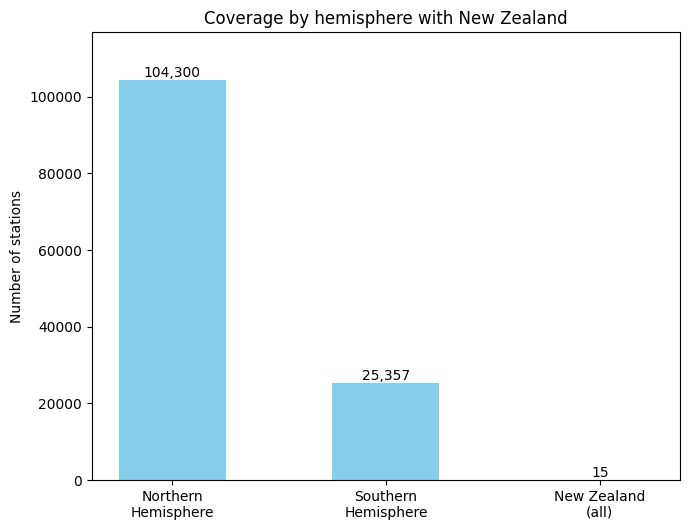

[time] Cell time (sec):   1.61
[time] Cell time (min):   0.03
[time] notebook_run_time (min):   0.36


In [12]:
bprint("TWO FIGURES")
# === TWO FIGURES IN ONE CELL ===
# 1) Southern focus (assignment intent): Southern Hemisphere, US territories south of the equator, ≥100 years (global)
# 2) Perspective: Northern Hemisphere, Southern Hemisphere, New Zealand (all)
# Notes:
#  - Keeps all diagnostic prints.
#  - Comments in British English.
#  - Filenames include 'dew59'.
 

cell_time = time.time()

# Ensure a figures folder exists
if 'figs_dir' not in globals():
    figs_dir = "figures"
os.makedirs(figs_dir, exist_ok=True)

# ---------- COUNTS (shared) ----------
print("[status] Computing station counts for requested views...")

# Hemispheres
south_hem = (
    enriched
    .filter(F.col("LATITUDE") < 0)
    .select("ID").distinct().count()
)
north_hem = (
    enriched
    .filter(F.col("LATITUDE") > 0)
    .select("ID").distinct().count()
)

# US territories (list per your earlier cells). We compute both 'south-only' and 'all' for transparency.
us_territories_all = (
    enriched
    .filter((F.col("COUNTRY_CODE") == "US") & (F.col("STATE").isin("PR", "GU", "AS", "VI", "MP")))
    .select("ID").distinct().count()
)
us_territories_south = (
    enriched
    .filter(
        (F.col("COUNTRY_CODE") == "US") &
        (F.col("STATE").isin("PR", "GU", "AS", "VI", "MP")) &
        (F.col("LATITUDE") < 0)
    )
    .select("ID").distinct().count()
)

# ≥100-year stations (global)
century_global = (
    enriched
    .filter((F.col("LASTYEAR") - F.col("FIRSTYEAR") + 1) >= 100)
    .select("ID").distinct().count()
)

# New Zealand
nz_all = (
    enriched
    .filter(F.col("COUNTRY_CODE") == "NZ")
    .select("ID").distinct().count()
)

print("[status] south_hem (all SH):", south_hem)
print("[status] north_hem (all NH):", north_hem)
print("[status] us_territories_all (global, excl. US states):", us_territories_all)
print("[status] us_territories_south (south of equator):", us_territories_south)
print("[status] century_global (≥100 years, global):", century_global)
print("[status] nz_all:", nz_all)

# ---------- FIGURE 1: Southern focus (assignment-style) ----------
labels1 = [
    "Southern\nHemisphere",
    "US territories\n(south of equator)",
    "≥100 years (global)"
]
values1 = [south_hem, us_territories_south, century_global]
print("[status] Fig1 Labels:", labels1)
print("[status] Fig1 Values:", values1)

plt.figure(figsize=(7., 5.4))
bars = plt.bar(labels1, values1,width=.5, color="skyblue")
plt.ylabel("Number of stations")
plt.title("Coverage (southern focus)")

# Numbers on top
top_val = max(values1) if values1 else 1
plt.ylim(0, top_val * 1.12)
for b in bars:
    h = b.get_height()
    x = b.get_x() + b.get_width() / 2
    y = h if h > 0 else 0
    plt.text(x, y, f"{int(h):,}", ha="center", va="bottom")

plt.xticks(rotation=0, ha="center")
plt.tight_layout()

outfile1 = os.path.join(figs_dir, "dew59_bar_southern_focus.png")
plt.savefig(outfile1, dpi=300, bbox_inches="tight")
print(f"[status] Figure 1 saved to: {outfile1}")

plt.show()
plt.close()

# ---------- FIGURE 2: Hemispheres + NZ (perspective) ----------
labels2 = ["Northern\nHemisphere", "Southern\nHemisphere", "New Zealand\n(all)"]
values2 = [north_hem, south_hem, nz_all]
print("[status] Fig2 Labels:", labels2)
print("[status] Fig2 Values:", values2)

plt.figure(figsize=(7., 5.4))
bars = plt.bar(labels2, values2, width=.5, color="skyblue")
plt.ylabel("Number of stations")
plt.title("Coverage by hemisphere with New Zealand")

top_val = max(values2) if values2 else 1
plt.ylim(0, top_val * 1.12)
for b in bars:
    h = b.get_height()
    x = b.get_x() + b.get_width() / 2
    y = h if h > 0 else 0
    plt.text(x, y, f"{int(h):,}", ha="center", va="bottom")

plt.xticks(rotation=0, ha="center")
plt.tight_layout()

outfile2 = os.path.join(figs_dir, "bar_hemi_plus_nz.png")
plt.savefig(outfile2, dpi=300, bbox_inches="tight")
print(f"[status] Figure 2 saved to: {outfile2}")

plt.show()
plt.close()

# ---------- TIMING ----------
cell_time = time.time() - cell_time
print(f"[time] Cell time (sec): {cell_time:6.2f}")
print(f"[time] Cell time (min): {cell_time/60:6.2f}")
print(f"[time] notebook_run_time (min): {(time.time() - notebook_run_time)/60:6.2f}")


__________________TWO FIGURES 2__________________
[status] bar_width -> 0.5
[status] bar_gap_factor -> 0.05
[status] side_margin -> 0.12
[status] Computing station counts for requested views...
[status] south_hem (all SH): 25357
[status] north_hem (all NH): 104300
[status] us_territories_all (global, excl. US states): 0
[status] us_territories_south (south of equator): 0
[status] century_global (≥100 years, global): 6824
[status] nz_all: 15
[status] Fig1 Labels: ['Southern Hemisphere', 'US territories (south of equator)', '≥100 years (global)']
[status] Fig1 Values: [25357, 0, 6824]
[status] Fig1 x positions -> [0.0, 0.55, 1.1]
[status] Figure 1 saved to: figures/dew59_bar_southern_focus.png


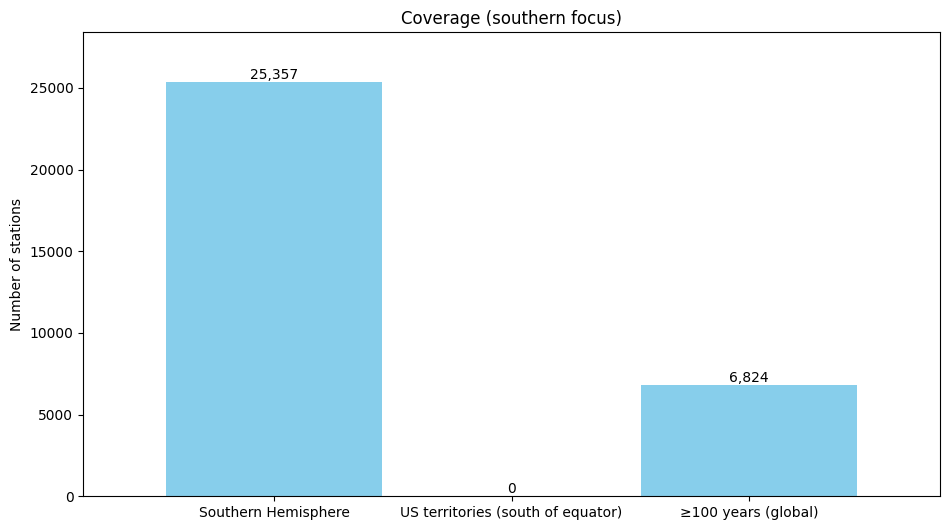

[status] Fig2 Labels: ['Northern Hemisphere', 'Southern Hemisphere', 'New Zealand (all)']
[status] Fig2 Values: [104300, 25357, 15]
[status] Fig2 x positions -> [0.0, 0.55, 1.1]
[status] Figure 2 saved to: figures/dew59_bar_hemi_plus_nz.png


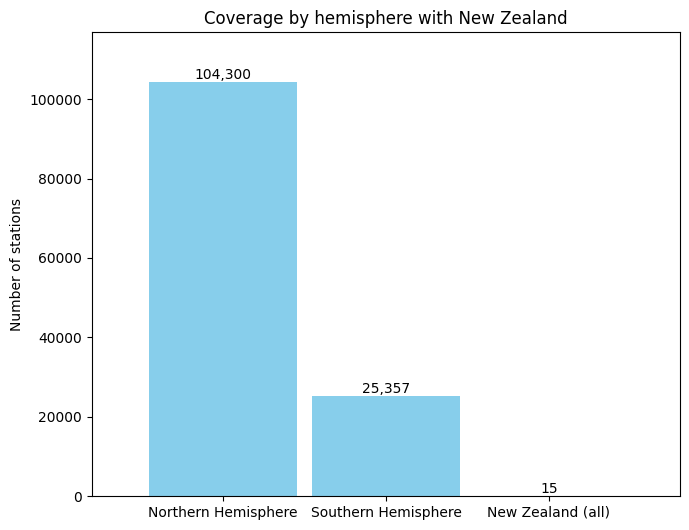

[time] Cell time (sec):   1.45
[time] Cell time (min):   0.02
[time] notebook_run_time (min):  0.38


In [13]:
bprint("TWO FIGURES 2") # === TWO FIGURES IN ONE CELL ===

# 1) Southern focus (assignment): Southern Hemisphere, US territories south of the equator, ≥100 years (global)
# 2) Perspective: Northern Hemisphere, Southern Hemisphere, New Zealand (all)
# Notes:
#  - Comments in British English; diagnostics use [status].
#  - Single cell creates both figures and saves them under 'figures/' with 'dew59' in filenames.
#  - Controls at top for bar thickness and true inter-bar gaps.
 

cell_time = time.time()

# ---------- Controls ----------
bar_width = 0.5         # thickness of each bar (0–1 relative to our custom step)
bar_gap_factor = 0.05     # extra gap between adjacent bars (0 = default/none, larger = more spacing)
side_margin = 0.12        # outer whitespace at chart edges (does not affect inter-bar gaps)
print(f"[status] bar_width -> {bar_width}")
print(f"[status] bar_gap_factor -> {bar_gap_factor}")
print(f"[status] side_margin -> {side_margin}")

# Ensure a figures folder exists
if 'figs_dir' not in globals():
    figs_dir = "figures"
os.makedirs(figs_dir, exist_ok=True)

# ---------- COUNTS (shared) ----------
print("[status] Computing station counts for requested views...")

# Hemispheres
south_hem = (
    enriched
    .filter(F.col("LATITUDE") < 0)
    .select("ID").distinct().count()
)
north_hem = (
    enriched
    .filter(F.col("LATITUDE") > 0)
    .select("ID").distinct().count()
)

# US territories: compute both (all vs south-only) for transparency; we use south-only in Figure 1
us_territories_all = (
    enriched
    .filter((F.col("COUNTRY_CODE") == "US") & (F.col("STATE").isin("PR", "GU", "AS", "VI", "MP")))
    .select("ID").distinct().count()
)
us_territories_south = (
    enriched
    .filter(
        (F.col("COUNTRY_CODE") == "US") &
        (F.col("STATE").isin("PR", "GU", "AS", "VI", "MP")) &
        (F.col("LATITUDE") < 0)
    )
    .select("ID").distinct().count()
)

# ≥100-year stations (global)
century_global = (
    enriched
    .filter((F.col("LASTYEAR") - F.col("FIRSTYEAR") + 1) >= 100)
    .select("ID").distinct().count()
)

# New Zealand
nz_all = (
    enriched
    .filter(F.col("COUNTRY_CODE") == "NZ")
    .select("ID").distinct().count()
)

print("[status] south_hem (all SH):", south_hem)
print("[status] north_hem (all NH):", north_hem)
print("[status] us_territories_all (global, excl. US states):", us_territories_all)
print("[status] us_territories_south (south of equator):", us_territories_south)
print("[status] century_global (≥100 years, global):", century_global)
print("[status] nz_all:", nz_all)

# =====================================================
# FIGURE 1: Southern focus (assignment-style)
# =====================================================
labels1 = [
    "Southern Hemisphere",
    "US territories (south of equator)",
    "≥100 years (global)"
]
values1 = [south_hem, us_territories_south, century_global]
print("[status] Fig1 Labels:", labels1)
print("[status] Fig1 Values:", values1)

# Numeric x positions with explicit inter-bar gaps
x1 = np.arange(len(labels1)) * (0.5 + bar_gap_factor)
print("[status] Fig1 x positions ->", x1.tolist())

plt.figure(figsize=(9.6, 5.4))
bars = plt.bar(x1, values1, width=bar_width, color="skyblue")
plt.ylabel("Number of stations")
plt.title("Coverage (southern focus)")

# Numbers on top
top_val = max(values1) if values1 else 1
plt.ylim(0, top_val * 1.12)
for i, b in enumerate(bars):
    h = b.get_height()
    x = x1[i]
    y = h if h > 0 else 0
    plt.text(x, y, f"{int(h):,}", ha="center", va="bottom")

# Category labels at our numeric x positions
plt.xticks(x1, labels1, rotation=0, ha="center")
plt.margins(x=side_margin)  # outer padding only
plt.tight_layout()

outfile1 = os.path.join(figs_dir, "dew59_bar_southern_focus.png")
plt.savefig(outfile1, dpi=300, bbox_inches="tight")
print(f"[status] Figure 1 saved to: {outfile1}")

plt.show()
plt.close()

# =====================================================
# FIGURE 2: Hemispheres + NZ (perspective)
# =====================================================
labels2 = ["Northern Hemisphere", "Southern Hemisphere", "New Zealand (all)"]
values2 = [north_hem, south_hem, nz_all]
print("[status] Fig2 Labels:", labels2)
print("[status] Fig2 Values:", values2)

x2 = np.arange(len(labels2)) * (0.5 + bar_gap_factor)
print("[status] Fig2 x positions ->", x2.tolist())

plt.figure(figsize=(7., 5.4))
bars = plt.bar(x2, values2, width=bar_width, color="skyblue")
plt.ylabel("Number of stations")
plt.title("Coverage by hemisphere with New Zealand")

top_val = max(values2) if values2 else 1
plt.ylim(0, top_val * 1.12)
for i, b in enumerate(bars):
    h = b.get_height()
    x = x2[i]
    y = h if h > 0 else 0
    plt.text(x, y, f"{int(h):,}", ha="center", va="bottom")

plt.xticks(x2, labels2, rotation=0, ha="center")
plt.margins(x=side_margin)
plt.tight_layout()

outfile2 = os.path.join(figs_dir, "dew59_bar_hemi_plus_nz.png")
plt.savefig(outfile2, dpi=300, bbox_inches="tight")
print(f"[status] Figure 2 saved to: {outfile2}")

plt.show()
plt.close()

# ---------- TIMING ----------
cell_time = time.time() - cell_time  
print(f"[time] Cell time (sec): {cell_time:6.2f}") 
print(f"[time] Cell time (min): {cell_time/60:6.2f}") 
print(f"[time] notebook_run_time (min): {(time.time() - notebook_run_time)/60:5.2f}")

In [14]:
bprint("AQ2(a)2")

# This notebook does not define `daily`/`daily_df`, so we read from storage.
 
 
cell_time = time.time()
# Confirm daily_root exists

try:
    daily_root
except NameError:
    raise NameError("daily_root is not defined in this notebook. "
                    "Please run the setup cell that defines WASBS_* paths.")

print(f"[diag] Reading daily data from directory: {daily_root}")

# GHCN-Daily schema (as per assignment starter): 
# ID, DATE (yyyymmdd), ELEMENT, VALUE, MFLAG, QFLAG, SFLAG, OBS_TIME (optional)
daily_schema = StructType([
    StructField("ID",       StringType(),  True),
    StructField("DATE",     StringType(),  True),   # keep as string; we parse later
    StructField("ELEMENT",  StringType(),  True),
    StructField("VALUE",    IntegerType(), True),
    StructField("MFLAG",    StringType(),  True),
    StructField("QFLAG",    StringType(),  True),
    StructField("SFLAG",    StringType(),  True),
    StructField("OBS_TIME", StringType(),  True)
])

# Read all CSV/GZ files in the daily directory; Spark handles .gz transparently
# We do not set header=True because GHCN text files have no header row.
daily_df = (spark.read
                 .option("header", "false")
                 .schema(daily_schema)
                 .csv(daily_root))

print("[diag] Loaded daily_df")

show_df(daily_df,name="daily_df")
# Light sanity checks (not expensive)
print("[diag] Row count sample (first action):", daily_df.limit(5).count()) 

 
# Tiny preview of PRCP presence
print("[diag] Distinct ELEMENT sample:")
daily_df.select("ELEMENT").distinct().orderBy("ELEMENT").show(10, truncate=False)

cell_time = time.time() - cell_time
print(f"[time] Cell time (sec)        : {cell_time:6.2f}") 
print(f"[time] Cell time (min)        : {cell_time/60:6.2f}") 
print(f"[time] notebook_run_time (min): {(time.time() - notebook_run_time)/60:6.2f}")


_____________________AQ2(a)2_____________________
[diag] Reading daily data from directory: wasbs://campus-data@madsstorage002.blob.core.windows.net/ghcnd/daily/
[diag] Loaded daily_df
______________________________________________________________________
name :  daily_df
root
 |-- ID: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- ELEMENT: string (nullable = true)
 |-- VALUE: integer (nullable = true)
 |-- MFLAG: string (nullable = true)
 |-- QFLAG: string (nullable = true)
 |-- SFLAG: string (nullable = true)
 |-- OBS_TIME: string (nullable = true)

[check] sample:
[INFO] Converting Spark → pandas for HTML display (rows: 10 )
[INFO] right_align (numeric columns): False


ID,DATE,ELEMENT,VALUE,MFLAG,QFLAG,SFLAG,OBS_TIME
ASN00030019,20100101,PRCP,24,None,None,a,None
ASN00030021,20100101,PRCP,200,None,None,a,None
ASN00030022,20100101,TMAX,294,None,None,a,None
ASN00030022,20100101,TMIN,215,None,None,a,None
ASN00030022,20100101,PRCP,408,None,None,a,None
ASN00029121,20100101,PRCP,820,None,None,a,None
ASN00029126,20100101,TMAX,371,None,None,S,None
ASN00029126,20100101,TMIN,225,None,None,S,None
ASN00029126,20100101,PRCP,0,None,None,a,None
ASN00029126,20100101,TAVG,298,H,None,S,None


[diag] Row count sample (first action): 5
[diag] Distinct ELEMENT sample:


[Stage 152:====================================================>(106 + 1) / 107]

+-------+
|ELEMENT|
+-------+
|ACMC   |
|ACMH   |
|ACSC   |
|ACSH   |
|ADPT   |
|ASLP   |
|ASTP   |
|AWBT   |
|AWDR   |
|AWND   |
+-------+
only showing top 10 rows

[time] Cell time (sec)        : 373.62
[time] Cell time (min)        :   6.23
[time] notebook_run_time (min):   6.61



______________________AQX(a)______________________
[INFO] Labels: ['≥1 core element', 'All 5 core elements']
[INFO] Values: [129570, 20504]
outfile:  figures/barchart-station-metadata-analysis.png
[INFO] Figure saved to: figures/barchart-station-metadata-analysis.png


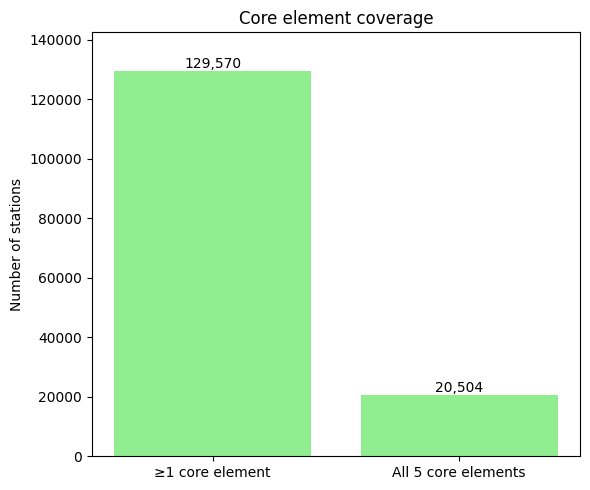

[time] core_time (sec)        :  0.07
[time] core_time (min)        :  0.00
[time] all5_time (sec)        :  0.07
[time] all5_time (min)        :  0.00
[time] Cell time (sec)        :   0.42
[time] Cell time (min)        :   0.01
[time] notebook_run_time (min):  6.62


In [15]:
bprint("AQX(a)")
cell_time = time.time()
core_stations = enriched.filter(F.col("CORE_ELEMENT_COUNT") > 0).count()
core_time     = time.time() - cell_time

all5_time     = time.time() 
all5          = enriched.filter(F.col("CORE_ELEMENT_COUNT") == 5).count()
all5_time     = time.time() - all5_time
core = {
    "≥1 core element": core_stations,
    "All 5 core elements": all5
}

 
labels = list(core.keys())
values = [core[k] for k in labels]
print("[INFO] Labels:", labels)
print("[INFO] Values:", values)

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, values, color="lightgreen")
plt.ylabel("Number of stations")
plt.title("Core element coverage")
plt.xticks(rotation=0, ha="center")

# Give a little headroom so the labels do not clip
plt.ylim(0, max(values) * 1.10)

# Add the numbers on top of each bar (with thousands separators)
for b in bars:
    height = b.get_height()
    x = b.get_x() + b.get_width() / 2
    y = height if height > 0 else 0
    plt.text(x, y, f"{int(height):,}", ha="center", va="bottom")

plt.tight_layout()

outfile = os.path.join(figs_dir, "barchart-station-metadata-analysis.png")
print("outfile: ", outfile)
plt.savefig(outfile, dpi=300)
 
print(f"[INFO] Figure saved to: {outfile}")
plt.show()
plt.close()
cell_time = time.time() - cell_time  
print(f"[time] core_time (sec)        : {core_time:5.2f}") 
print(f"[time] core_time (min)        : {core_time/60:5.2f}")
print(f"[time] all5_time (sec)        : {all5_time:5.2f}") 
print(f"[time] all5_time (min)        : {all5_time/60:5.2f}") 
print(f"[time] Cell time (sec)        : {cell_time:6.2f}") 
print(f"[time] Cell time (min)        : {cell_time/60:6.2f}") 
print(f"[time] notebook_run_time (min): {(time.time() - notebook_run_time)/60:5.2f}")

In [ ]:
bprint("AQ2(a)") # 3 — PRCP by year × country using Spark .agg() 
# --------------------------------------------------------------------
# average *daily* rainfall (mm) per year & country.
cell_time = time.time()

# Be robust to column name case (ID vs id, DATE vs date, etc.)
id_col      = 'id'      if 'id'      in daily_df.columns else 'ID'
date_col    = 'date'    if 'date'    in daily_df.columns else 'DATE'
elem_col    = 'element' if 'element' in daily_df.columns else 'ELEMENT'
value_col   = 'value'   if 'value'   in daily_df.columns else 'VALUE'

print(f"[check] Using columns: id={id_col}, date={date_col}, element={elem_col}, value={value_col}")
filter_time = time.time()
# Filter to precipitation only
prcp_df = daily_df.filter(F.col(elem_col) == F.lit('PRCP'))
print(f"[check] PRCP record count: {prcp_df.count():,}")
print("[diag] prcp_df schema:")
prcp_df.printSchema()
show_as_html(prcp_df,1)
# Extract country code (first two characters of station ID)
prcp_df = prcp_df.withColumn("country_code", F.substring(F.col(id_col), 1, 2))
print("[diag] prcp_df schema:")
prcp_df.printSchema()
show_as_html(prcp_df,1)
# Parse year from DATE (stored as yyyymmdd string/int)
prcp_df = prcp_df.withColumn(
    "year",
    F.year(F.to_date(F.col(date_col).cast("string"), "yyyyMMdd"))
)
filter_time = time.time() - filter_time 
after_time = time.time()
show_as_html(prcp_df,1)
# Convert PRCP from tenths of mm to mm, and drop negatives just in case
prcp_df = prcp_df.withColumn("prcp_mm", (F.col(value_col) / F.lit(10.0)).cast("double"))
print("[diag] prcp_df schema:")
prcp_df.printSchema()
show_as_html(prcp_df,1)
prcp_df = prcp_df.filter(F.col("prcp_mm") >= 0)
print("[diag] prcp_df schema:")
prcp_df.printSchema()
show_as_html(prcp_df,1)
q2a_agg_time = time.time()
# >>> The required aggregation <<<
q2a_agg_df = (
    prcp_df
    .groupBy("year", "country_code")
    .agg(F.avg("prcp_mm").alias("avg_daily_prcp_mm"))
    .orderBy("year", "country_code")
)
after_time = time.time() - after_time  
q2a_agg_time = time.time() - q2a_agg_time   
print("[diag] q2a_agg_df schema:")
q2a_agg_df.printSchema()
show_as_html(q2a_agg_df,1)
# Write the aggregated table for visualisation
 

print(f"[diag] Writing Q2(a)3 output to: {precip_write_name}")
(q2a_agg_df.write.mode("overwrite").parquet(precip_write_name))
 
print(f"[time] q2a_agg_time      (sec): {q2a_agg_time:11.2f}") 
print(f"[time] q2a_agg_time      (min): {q2a_agg_time/60:11.2f}")  

cell_time = time.time() - cell_time
print(f"[time] Filter time (sec): {filter_time:11.2f}") 
print(f"[time] Filter time (min): {filter_time/60:11.2f}")
print(f"[time] After time (sec): {after_time:11.2f}") 
print(f"[time] After time (min): {after_time/60:11.2f}")
print(f"[time] Cell time (sec): {cell_time:11.2f}") 
print(f"[time] Cell time (min): {cell_time/60:11.2f}")  
print(f"[time] notebook_run_time (min): {(time.time() - notebook_run_time)/60:5.2f}")


______________________AQ2(a)______________________
[check] Using columns: id=ID, date=DATE, element=ELEMENT, value=VALUE


[Stage 161:====================================>                 (73 + 8) / 107]

[check] PRCP record count: 1,084,610,240
[diag] prcp_df schema:
root
 |-- ID: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- ELEMENT: string (nullable = true)
 |-- VALUE: integer (nullable = true)
 |-- MFLAG: string (nullable = true)
 |-- QFLAG: string (nullable = true)
 |-- SFLAG: string (nullable = true)
 |-- OBS_TIME: string (nullable = true)



,ID,DATE,ELEMENT,VALUE,MFLAG,QFLAG,SFLAG,OBS_TIME
0,ASN00030019,20100101,PRCP,24,None,None,a,None


[diag] prcp_df schema:
root
 |-- ID: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- ELEMENT: string (nullable = true)
 |-- VALUE: integer (nullable = true)
 |-- MFLAG: string (nullable = true)
 |-- QFLAG: string (nullable = true)
 |-- SFLAG: string (nullable = true)
 |-- OBS_TIME: string (nullable = true)
 |-- country_code: string (nullable = true)



,ID,DATE,ELEMENT,VALUE,MFLAG,QFLAG,SFLAG,OBS_TIME,country_code
0,ASN00030019,20100101,PRCP,24,None,None,a,None,AS


,ID,DATE,ELEMENT,VALUE,MFLAG,QFLAG,SFLAG,OBS_TIME,country_code,year
0,ASN00030019,20100101,PRCP,24,None,None,a,None,AS,2010


[diag] prcp_df schema:
root
 |-- ID: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- ELEMENT: string (nullable = true)
 |-- VALUE: integer (nullable = true)
 |-- MFLAG: string (nullable = true)
 |-- QFLAG: string (nullable = true)
 |-- SFLAG: string (nullable = true)
 |-- OBS_TIME: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- prcp_mm: double (nullable = true)



,ID,DATE,ELEMENT,VALUE,MFLAG,QFLAG,SFLAG,OBS_TIME,country_code,year,prcp_mm
0,ASN00030019,20100101,PRCP,24,None,None,a,None,AS,2010,2.4


[diag] prcp_df schema:
root
 |-- ID: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- ELEMENT: string (nullable = true)
 |-- VALUE: integer (nullable = true)
 |-- MFLAG: string (nullable = true)
 |-- QFLAG: string (nullable = true)
 |-- SFLAG: string (nullable = true)
 |-- OBS_TIME: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- prcp_mm: double (nullable = true)



,ID,DATE,ELEMENT,VALUE,MFLAG,QFLAG,SFLAG,OBS_TIME,country_code,year,prcp_mm
0,ASN00030019,20100101,PRCP,24,None,None,a,None,AS,2010,2.4


[diag] q2a_agg_df schema:
root
 |-- year: integer (nullable = true)
 |-- country_code: string (nullable = true)
 |-- avg_daily_prcp_mm: double (nullable = true)



In [ ]:
bprint("Ananalysis  A X (11) ") #  spark protect for vscode runs
cell_time = time.time() 
val       = spark.range(1).select(F.date_format(F.current_timestamp(), 'yyyy.MM.dd HH:mm').alias('t')).first()['t']

CITIES = [
    ("Auckland",     -36.8485, 174.7633),
    ("Wellington",   -41.2866, 174.7756),
    ("Christchurch", -43.5321, 172.6362),
]

# Try Spark benchmark  
spark_timings = None
try:
    from pyspark.sql import SparkSession
    if SparkSession.getActiveSession() is not None:
        spark_timings = benchmark_spark_distances(CITIES, repeats=5)
except Exception:
    pass

# Always run Python benchmark
py_timings = benchmark_python_distances(CITIES, repeats=100000)

# Print
print("=== Timing (seconds) ===")
if spark_timings:
    print(f"Spark  | pairs={spark_timings['spark_pairs']}, repeats={spark_timings['spark_repeats']}")
    print(f"  haversine: {spark_timings['spark_haversine_sec']:.6f}")
    print(f"  slc:       {spark_timings['spark_slc_sec']:.6f}")
else:
    print("Spark  | not detected (skipped)")

print(f"Python | pairs={py_timings['pairs']}, repeats={py_timings['repeats']}")
print(f"  haversine: {py_timings['python_haversine_sec']:.6f}")
print(f"  slc:       {py_timings['python_slc_sec']:.6f}")
print(f"[time] current time           :  {val}")
print(f"[time] Cell time (sec)        : {cell_time:6.2f}") 
print(f"[time] Cell time (min)        : {cell_time/60:6.2f}") 
print(f"[time] notebook_run_time (min):  {(time.time() - notebook_run_time)/60:5.2f}")

In [ ]:
bprint("stop_spark()") # Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI
cell_time = time.time()
stop_spark()

val = spark.range(1).select(F.date_format(F.current_timestamp(), 'yyyy.MM.dd HH:mm').alias('t')).first()['t']
cell_time = time.time() - cell_time  
print(f"[time] current time           :  {val}")
print(f"[time] Cell time (sec)        : {cell_time:6.2f}") 
print(f"[time] Cell time (min)        : {cell_time/60:6.2f}") 
print(f"[time] notebook_run_time (min):  {(time.time() - notebook_run_time)/60:5.2f}")